In [81]:
# Dataset Shape
dataset.shape # 1358 rows, 7 columns

(1358, 7)

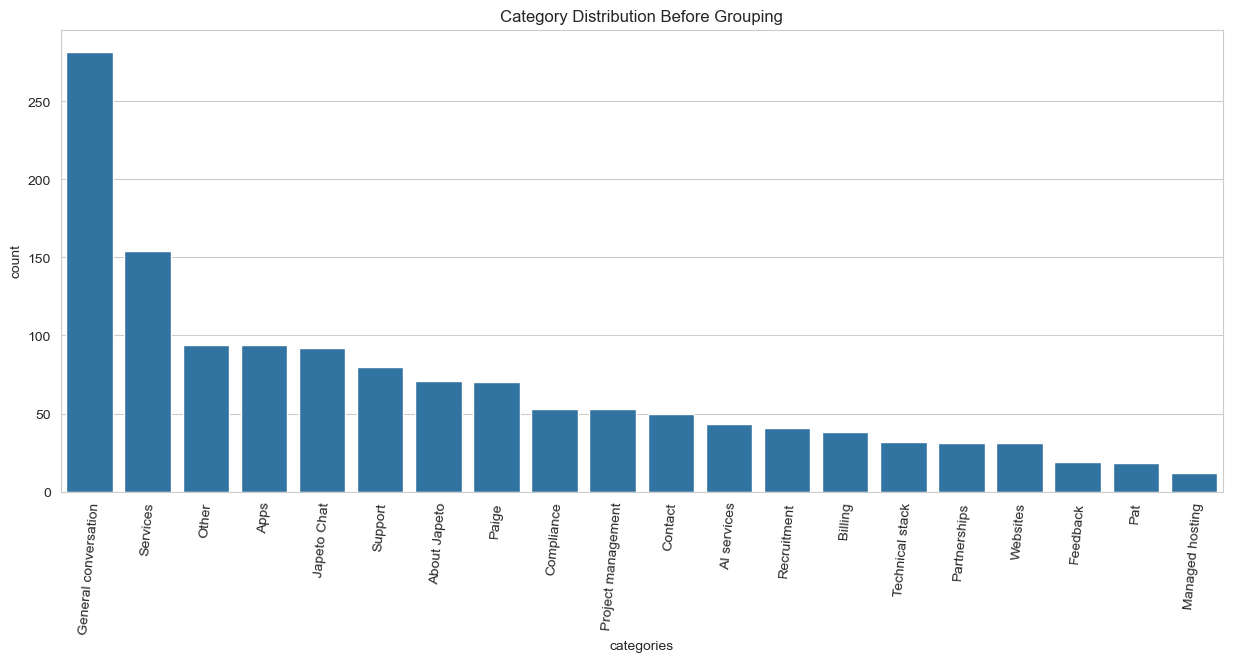

In [83]:
import seaborn as sbn
import matplotlib.pyplot as plt

# Plot the dataset
plt.figure(figsize=(15, 6))
sbn.countplot(x="categories", data=dataset, order=dataset['categories'].value_counts().index)
sbn.set_style("whitegrid")
plt.xticks(rotation=85)
plt.title("Category Distribution Before Grouping")
plt.show()

In [85]:
# Drop the unnecessary columns
dataset.drop(["session_id", "message_time", "user_message", "response_source", "intent_name"], axis=1, inplace=True)
dataset.head()

,chatbot_response,categories
0,"I'm happy to chat with you, but I'm a sales an...",Other
1,I'm an AI Assistant... I don't know how I am. ...,General conversation
2,I'm sorry to hear that. \n\nAre you having an ...,Other
3,I'm happy to assist you with any questions you...,General conversation
4,Hi! Thanks for chatting. I'm an AI Assistant f...,Services


In [87]:
import re
from string import punctuation

def pre_process(text):
    pro_text = text.lower()
    pro_text = re.sub(f"[{re.escape(punctuation)}]", "", pro_text)
    pro_text = " ".join(pro_text.split())
    return pro_text

dataset["chatbot_response"] = dataset["chatbot_response"].apply(lambda x:pre_process(x))

In [89]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')
nltk.download('stopwords')


def get_words():
    return set(stopwords.words('english'))

def remove_stop_words(text):
    words = get_words()
    tokens = word_tokenize(text)
    filters = [x for x in tokens if x not in words]
    no_stop_words = " ".join(filters)
    return no_stop_words

dataset["chatbot_response"] = dataset["chatbot_response"].apply(lambda x:remove_stop_words(x))

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/ch.4rl/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ch.4rl/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

def stem(text):
    tokens = word_tokenize(text)

    po_st = PorterStemmer()
    req_words = [po_st.stem(x) for x in tokens]

    stemmed_words = ' '.join(req_words)

    return stemmed_words

dataset["chatbot_response"] = dataset["chatbot_response"].apply(lambda x:stem(x))

In [93]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

def lemmatize(text):
    lemmatizer = WordNetLemmatizer()
    tokens = text.split()
    req_words = [lemmatizer.lemmatize(x, 'v') for x in tokens]
    lemmnatized_word = " ".join(req_words)

    return lemmnatized_word

dataset["chatbot_response"] = dataset["chatbot_response"].apply(lambda x:lemmatize(x))

[nltk_data] Downloading package wordnet to /Users/ch.4rl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [95]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Turn text to numerical vectors
vectorizer = TfidfVectorizer(max_features=1500)
vector = vectorizer.fit_transform(dataset["chatbot_response"])

vector = vector.toarray()
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [97]:
from sklearn.preprocessing import LabelEncoder
# Apply label encoding
le = LabelEncoder()
label =le.fit_transform(dataset['categories'])

In [99]:
# Train Test Split the dataset: 20% for testing and 80% for training
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(vector, label, test_size=0.2, random_state=42)

In [101]:
# GridSearch for SVM
svm_param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'poly'],
    'gamma': ['scale'],
    'degree': [2]
}

In [103]:
# Train an SVM model with the dataset
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(SVC(), svm_param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)
model = grid.best_estimator_
print(f"Best SVM Params: {grid.best_params_}")

Best SVM Params: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'linear'}


In [104]:
# Accuracy of the SVM model
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"SVM Model Accuracy: {acc * 100:.2f}%")

SVM Model Accuracy: 65.81%


In [104]:
# Accuracy of the SVM model
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"SVM Model Accuracy: {acc * 100:.2f}%")

SVM Model Accuracy: 65.81%


In [71]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

print("Classification Report:")
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
display_labels = le.classes_[unique_labels]
print(classification_report(y_test, y_pred, target_names=display_labels, zero_division=0))

Classification Report:
                      precision    recall  f1-score   support

         AI services       0.80      0.40      0.53        10
        About Japeto       0.40      0.47      0.43        17
                Apps       0.89      0.85      0.87        20
             Billing       0.67      0.67      0.67         6
          Compliance       0.80      0.80      0.80        10
             Contact       0.75      0.60      0.67        10
            Feedback       1.00      0.67      0.80         3
General conversation       0.73      0.93      0.82        57
         Japeto Chat       0.81      0.59      0.68        22
     Managed hosting       0.40      0.50      0.44         4
               Other       0.50      0.38      0.43        21
               Paige       0.45      0.33      0.38        15
        Partnerships       1.00      1.00      1.00         1
                 Pat       0.17      0.50      0.25         2
  Project management       0.83      0.91     

In [71]:
# Classification report
from sklearn.metrics import classification_report
import numpy as np

print("Classification Report:")
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
display_labels = le.classes_[unique_labels]
print(classification_report(y_test, y_pred, target_names=display_labels, zero_division=0))

Classification Report:
                      precision    recall  f1-score   support

         AI services       0.80      0.40      0.53        10
        About Japeto       0.40      0.47      0.43        17
                Apps       0.89      0.85      0.87        20
             Billing       0.67      0.67      0.67         6
          Compliance       0.80      0.80      0.80        10
             Contact       0.75      0.60      0.67        10
            Feedback       1.00      0.67      0.80         3
General conversation       0.73      0.93      0.82        57
         Japeto Chat       0.81      0.59      0.68        22
     Managed hosting       0.40      0.50      0.44         4
               Other       0.50      0.38      0.43        21
               Paige       0.45      0.33      0.38        15
        Partnerships       1.00      1.00      1.00         1
                 Pat       0.17      0.50      0.25         2
  Project management       0.83      0.91     

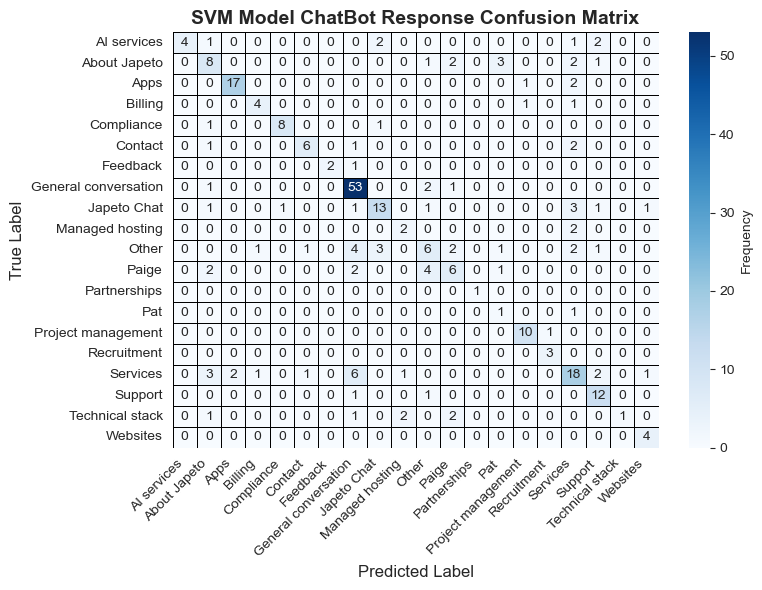

In [107]:
# Confusion Matrix Score
from sklearn.metrics import confusion_matrix

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sbn.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=display_labels, yticklabels=display_labels,
          linewidths=0.5, linecolor='black', cbar_kws={'label': 'Frequency'})
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.title('SVM Model ChatBot Response Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

In [109]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB

gaussian_model = GaussianNB()
multinomial_model = MultinomialNB()

gaussian_model.fit(X_train, y_train)
multinomial_model.fit(X_train, y_train)

y_gaussian_pred = gaussian_model.predict(X_test)
y_multinomial_pred = multinomial_model.predict(X_test)

gaussian_accuracy = accuracy_score(y_test, y_gaussian_pred)
multinomial_accuracy = accuracy_score(y_test, y_multinomial_pred)

print(f"Gaussian Model Accuracy: {gaussian_accuracy  * 100:.2f}%")
print(f"Multinomial Model Accuracy: {multinomial_accuracy * 100:.2f}%")

Gaussian Model Accuracy: 57.35%
Multinomial Model Accuracy: 52.57%
